## Deep Operator Networks (DeepONets)

In [2]:
!pip install equinox
!pip install optax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 4.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
import jax
import jax.numpy as jnp
import equinox as eqx

class DeepONet(eqx.Module):
    branch: eqx.nn.MLP
    trunk: eqx.nn.MLP
    fc: eqx.nn.Linear

    def __init__(self, latent_features: int, out_features: int, branch: eqx.nn.MLP, trunk: eqx.nn.MLP, *, key):
        self.branch = branch
        self.trunk = trunk
        self.fc = eqx.nn.Linear(latent_features, out_features, use_bias=False, key=key)

    def __call__(self, y, u):
        return self.fc(self.trunk(y) * self.branch(u))


key = jax.random.PRNGKey(0)
k_branch, k_trunk, k_fc = jax.random.split(key, 3)

branch = eqx.nn.MLP(
    in_size=100,
    out_size=75,
    width_size=75,
    depth=4,
    activation=jax.nn.tanh,
    final_activation=lambda x: x,
    key=k_branch,
)
trunk = eqx.nn.MLP(
    in_size=1,
    out_size=75,
    width_size=75,
    depth=4,
    activation=jax.nn.tanh,
    final_activation=lambda x: x,
    key=k_trunk,
)
model = DeepONet(latent_features=75, out_features=1, branch=branch, trunk=trunk, key=k_fc)

In [6]:
!pip install quadax

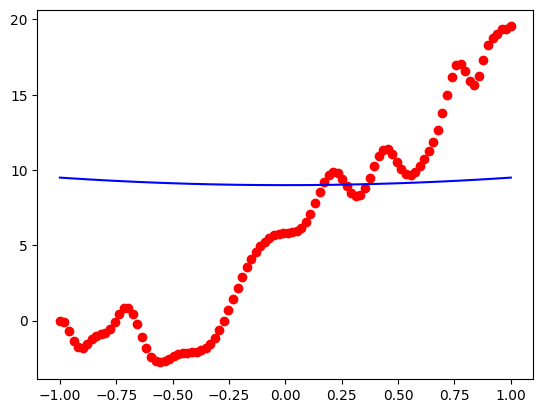

In [42]:
import jax
import jax.numpy as jnp
from quadax import cumulative_trapezoid
from matplotlib import pyplot as plt

# Generating data with Chebyshev polynomials
# Training data points are tuples (u, y, G(u)(y))
# u is our input function
# y is query location
# G(u)(y) truth operator output at y, computed numerically solving the ODE/PDE


# Implementing Chebyshev series
def chebval(x, coeff):
    b1 = jnp.zeros_like(x)
    b2 = jnp.zeros_like(x)
    for a in coeff[:0:-1]:
        # Clenshaw recursion: https://en.wikipedia.org/wiki/Clenshaw_algorithm
        b0 = 2.0 * x * b1 - b2 + a 
        b2, b1 = b1, b0
    return x * b1 - b2 + coeff[0]

def random_chebyshev(key, n, M, degree):
    coeff = jax.random.uniform(
        key, 
        shape=(degree + 1,),
        minval=-abs(M),
        maxval=abs(M)
    )
    x = jnp.linspace(-1.0, 1.0, n)
    y = chebval(x, coeff)
    return x, y, coeff

key = jax.random.PRNGKey(0)
x, y, coeff = random_chebyshev(key, 100, 10, 30)
y_int = cumulative_trapezoid(y, x=x, initial=0)
plt.plot(x, y_int, 'ro', x, y[0] + 0.5 * x**2, 'b-')
plt.show()

In [43]:
# Generate data tuples
def generate_data(
    key,
    n_samples,
    a,
    b,
    n_sensors,
    n_points,
    M,
    degree,
    y0=0.0,
    random_query=False,
):
    """
    Generate training tuples (y, u, G(u)(y))
    """
    keys = jax.random.split(key, n_samples + 1)
    key_query = keys[0]
    keys_fun = keys[1:]

    def sample_u(k):
        _, u_vals, coeff = random_chebyshev(k, n_sensors, M, degree)
        return u_vals, coeff

    u, _ = jax.vmap(sample_u)(keys_fun)

    if random_query:
        y = jax.random.uniform(
            key_query,
            shape=(n_samples, n_points),
            minval=a,
            maxval=b,
        )
    else:
        y = jnp.tile(jnp.linspace(a, b, n_points), (n_samples, 1))

    xp = jnp.linspace(a, b, n_sensors)
    Guy_on_xp = jax.vmap(lambda ui: cumulative_trapezoid(ui, x=xp, initial=y0))(u)

    Guy = jax.vmap(lambda yy, Gi: jnp.interp(yy, xp, Gi))(y, Guy_on_xp)

    return y, u, Guy

key = jax.random.PRNGKey(0)
ys,us,Guys = generate_data(key,100,0,2,100,100,5,20)
ys.shape,us.shape,Guys.shape

((100, 100), (100, 100), (100, 100))

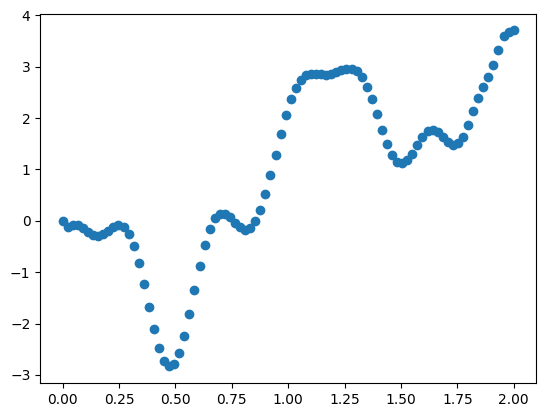

In [46]:
x = jnp.linspace(0,2,100)

plt.scatter(ys[2].squeeze(),Guys[2].squeeze())